In [2]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

In [3]:
# !pip install bokeh

In [25]:
from bokeh.io import output_notebook
from bokeh.models import BoxAnnotation, Label, Legend, Span
from bokeh.palettes import brewer
from bokeh.plotting import figure, show

output_notebook()

Loading BokehJS ...

In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

### Data

In [4]:
data_monthly = pd.read_csv(pm.get_data("monthly_in_situ_co2_mlo.csv"), header=56)

# - replace -99.99 with NaN
data_monthly.replace(to_replace=-99.99, value=np.nan, inplace=True)

# fix column names
cols = [
    "year",
    "month",
    "--",
    "--",
    "CO2",
    "seasonaly_adjusted",
    "fit",
    "seasonally_adjusted_fit",
    "CO2_filled",
    "seasonally_adjusted_filled",
]
data_monthly.columns = cols
cols.remove("--")
cols.remove("--")
data_monthly = data_monthly[cols]


In [5]:
data_monthly.shape

(720, 8)

In [6]:
data_monthly.head()

,year,month,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled
0,1958,1,NaN,NaN,NaN,NaN,NaN,NaN
1,1958,2,NaN,NaN,NaN,NaN,NaN,NaN
2,1958,3,315.69,314.43,316.18,314.90,315.69,314.43
3,1958,4,317.46,315.15,317.30,314.98,317.46,315.15
4,1958,5,317.50,314.73,317.84,315.06,317.50,314.73


In [7]:
# drop rows with nan
data_monthly.dropna(inplace=True)

# fix time index
data_monthly["day"] = 15
data_monthly.index = pd.to_datetime(data_monthly[["year", "month", "day"]])
cols.remove("year")
cols.remove("month")
data_monthly = data_monthly[cols]

data_monthly.head(5)

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled
1958-03-15,315.69,314.43,316.18,314.90,315.69,314.43
1958-04-15,317.46,315.15,317.30,314.98,317.46,315.15
1958-05-15,317.50,314.73,317.84,315.06,317.50,314.73
1958-07-15,315.86,315.17,315.87,315.22,315.86,315.17
1958-08-15,314.93,316.17,314.01,315.29,314.93,316.17


In [8]:
data_monthly.index.min(), data_monthly.index.max()

(Timestamp('1958-03-15 00:00:00'), Timestamp('2017-06-15 00:00:00'))

In [9]:
# function to convert datetimes to numbers that are useful to algorithms
#   this will be useful later when doing prediction


def dates_to_idx(timelist):
    reference_time = pd.to_datetime("1958-03-15")
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    return np.asarray(t)


t = dates_to_idx(data_monthly.index)

In [10]:


# normalize CO2 levels
y = data_monthly["CO2"].values
first_co2 = y[0]
std_co2 = np.std(y)
y_n = (y - first_co2) / std_co2

data_monthly = data_monthly.assign(t=t)
data_monthly = data_monthly.assign(y_n=y_n)

In [11]:
# normalize CO2 levels
y = data_monthly["CO2"].values
first_co2 = y[0]
std_co2 = np.std(y)
y_n = (y - first_co2) / std_co2

data_monthly = data_monthly.assign(t=t)
data_monthly = data_monthly.assign(y_n=y_n)

In [12]:
data_monthly.head()

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled,t,y_n
1958-03-15,315.69,314.43,316.18,314.90,315.69,314.43,0.000000,0.000000
1958-04-15,317.46,315.15,317.30,314.98,317.46,315.15,0.084932,0.066821
1958-05-15,317.50,314.73,317.84,315.06,317.50,314.73,0.167123,0.068331
1958-07-15,315.86,315.17,315.87,315.22,315.86,315.17,0.334247,0.006418
1958-08-15,314.93,316.17,314.01,315.29,314.93,316.17,0.419178,-0.028691


##### Use the stretch of data from before 2004 as the "training" set. The data from 2004 to current we'll use to test our predictions.

In [13]:
# split into training and test set
sep_idx = data_monthly.index.searchsorted(pd.to_datetime("2003-12-15"))
data_early = data_monthly.iloc[: sep_idx + 1, :]
data_later = data_monthly.iloc[sep_idx:, :]

In [14]:
data_early.tail()

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled,t,y_n
2003-08-15,374.48,375.94,374.43,375.92,374.48,375.94,45.449315,2.219432
2003-09-15,372.98,376.32,372.74,376.10,372.98,376.32,45.534247,2.162804
2003-10-15,373.00,376.47,372.81,376.27,373.00,376.47,45.616438,2.163559
2003-11-15,374.35,376.53,374.26,376.43,374.35,376.53,45.701370,2.214524
2003-12-15,375.69,376.59,375.69,376.57,375.69,376.59,45.783562,2.265111


In [17]:
data_monthly.head()

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled,t,y_n
1958-03-15,315.69,314.43,316.18,314.90,315.69,314.43,0.000000,0.000000
1958-04-15,317.46,315.15,317.30,314.98,317.46,315.15,0.084932,0.066821
1958-05-15,317.50,314.73,317.84,315.06,317.50,314.73,0.167123,0.068331
1958-07-15,315.86,315.17,315.87,315.22,315.86,315.17,0.334247,0.006418
1958-08-15,314.93,316.17,314.01,315.29,314.93,316.17,0.419178,-0.028691


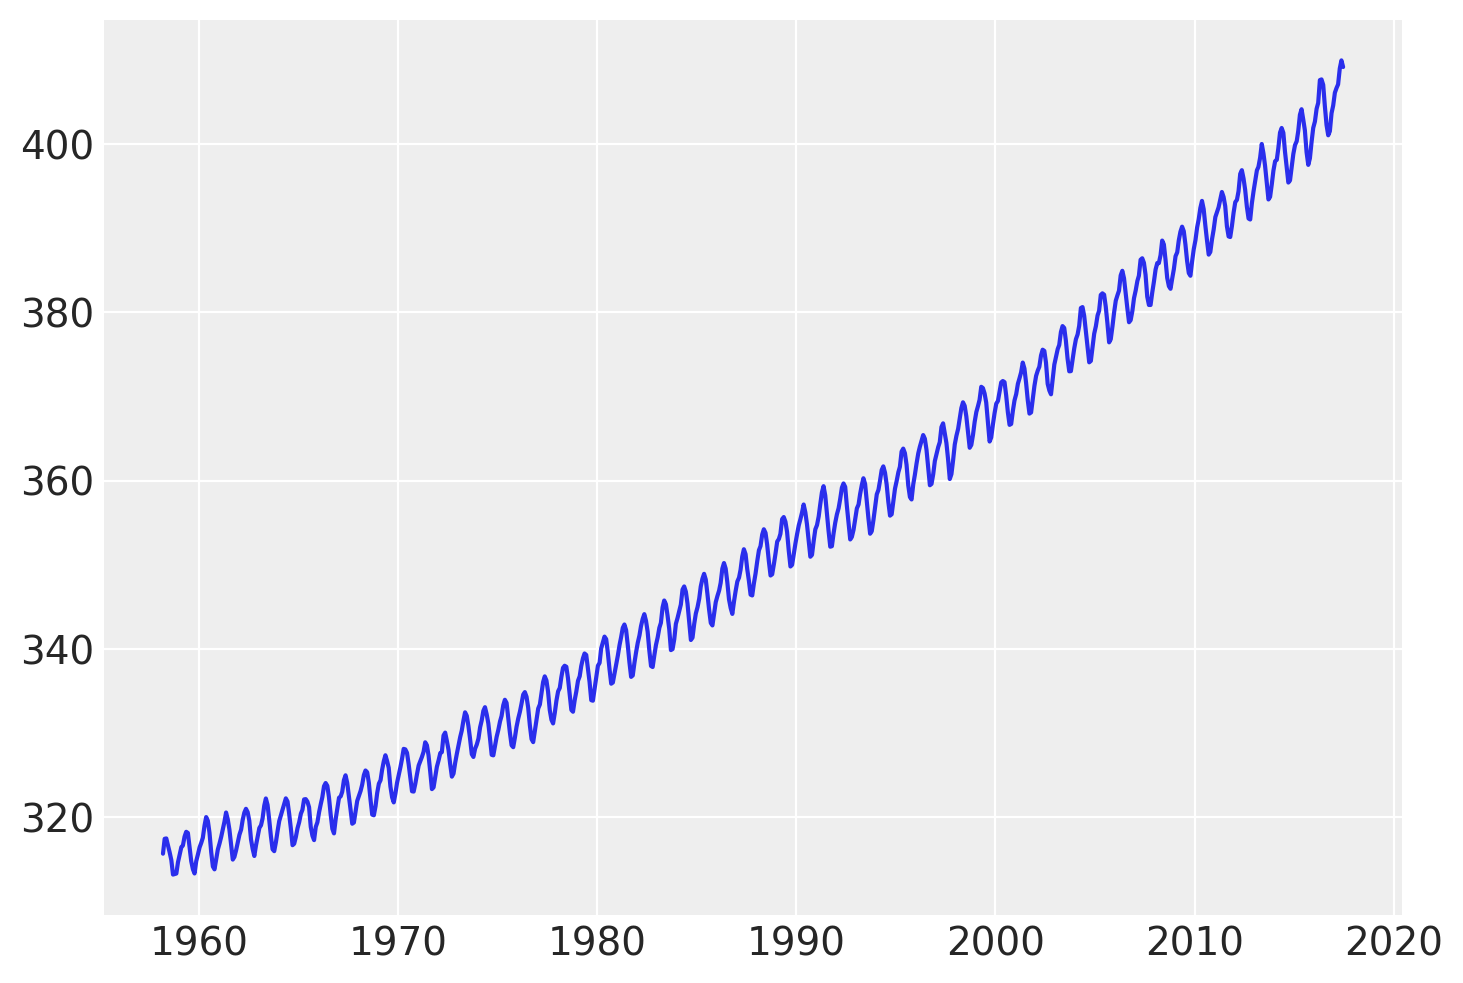

In [18]:
plt.plot(data_monthly.index, data_monthly["CO2"]);

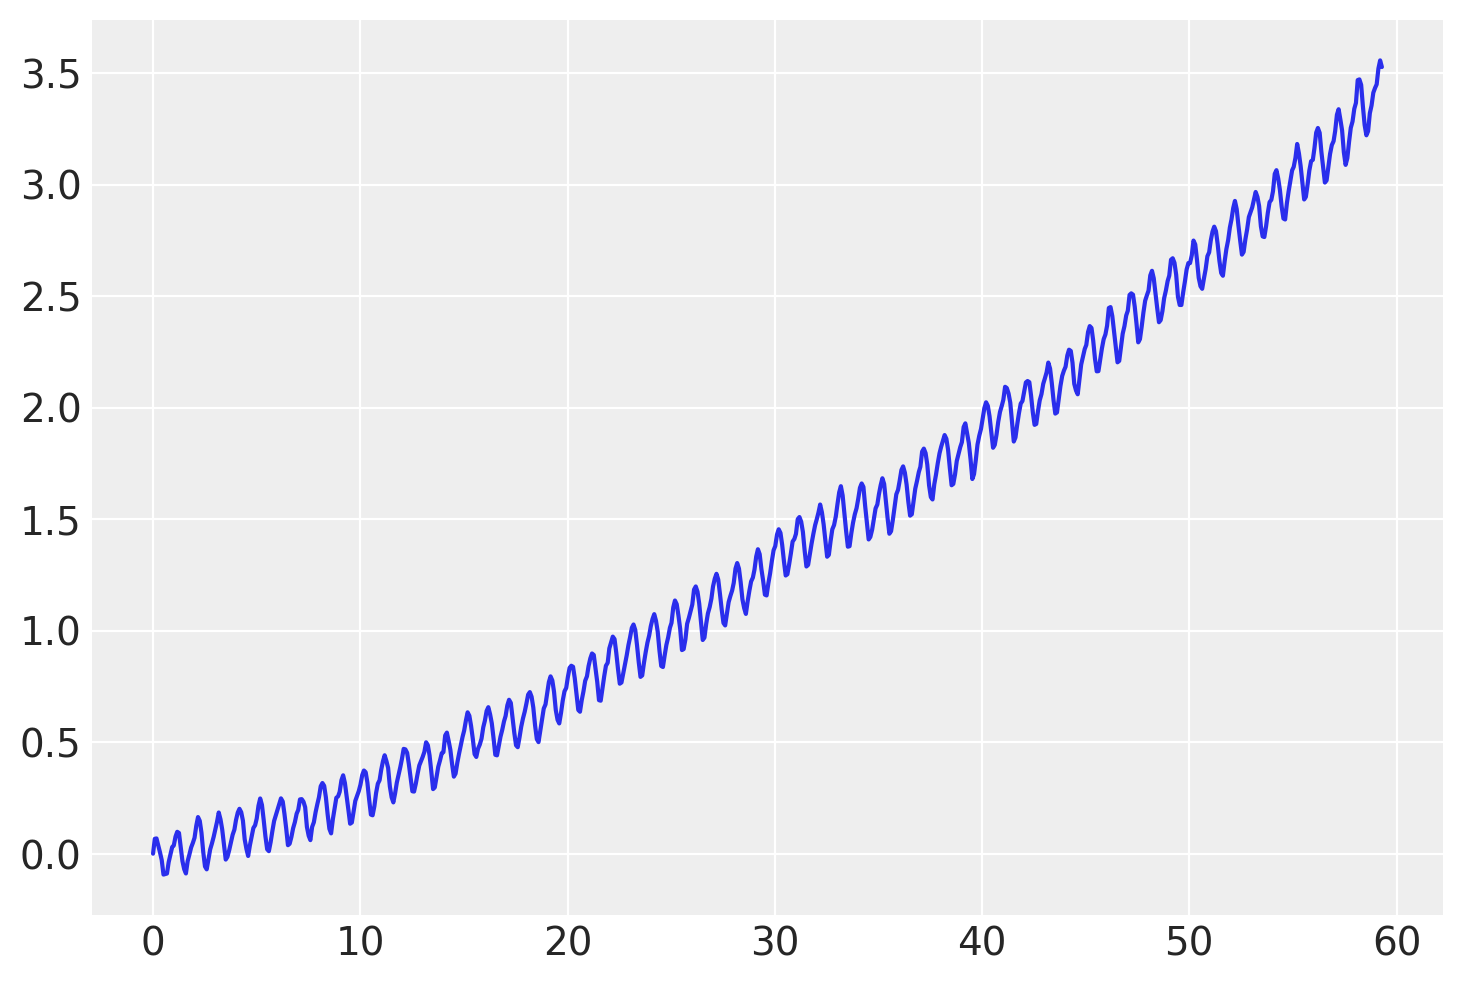

In [19]:
plt.plot(data_monthly.t, data_monthly["y_n"]);

### Modeling the Keeling Curve using GPs

In [55]:
X, y = data_early.t.values, data_early.y_n.values
X_test, y_test = data_later.t.values, data_later.y_n.values
X.shape, y.shape, X_test.shape, y_test.shape

((545,), (545,), (163,), (163,))

In [90]:
with pm.Model() as model1:
    sigma = pm.HalfNormal('sigma', 5)
    
    alpha = pm.Normal('alpha', 0, 2)
    mean = pm.gp.mean.Linear(coeffs=alpha)
    
    
    l = pm.Exponential('l', 1)
    n = pm.Exponential('n', 1)
    K = n**2 * pm.gp.cov.ExpQuad(1, l)    
    
    gp = pm.gp.MarginalSparse(mean_func=mean, cov_func=K)
    Xu = pm.gp.util.kmeans_inducing_points(10, X.reshape(-1,1))
    
    obs = gp.marginal_likelihood("obs", X=X.reshape(-1,1), Xu=Xu, y=y, noise=sigma)

In [91]:
with model1:
    gp_trace = pm.sample(1000)

<ipython-input-91-a66e9981c3da>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  gp_trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n, l, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/.dcm/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


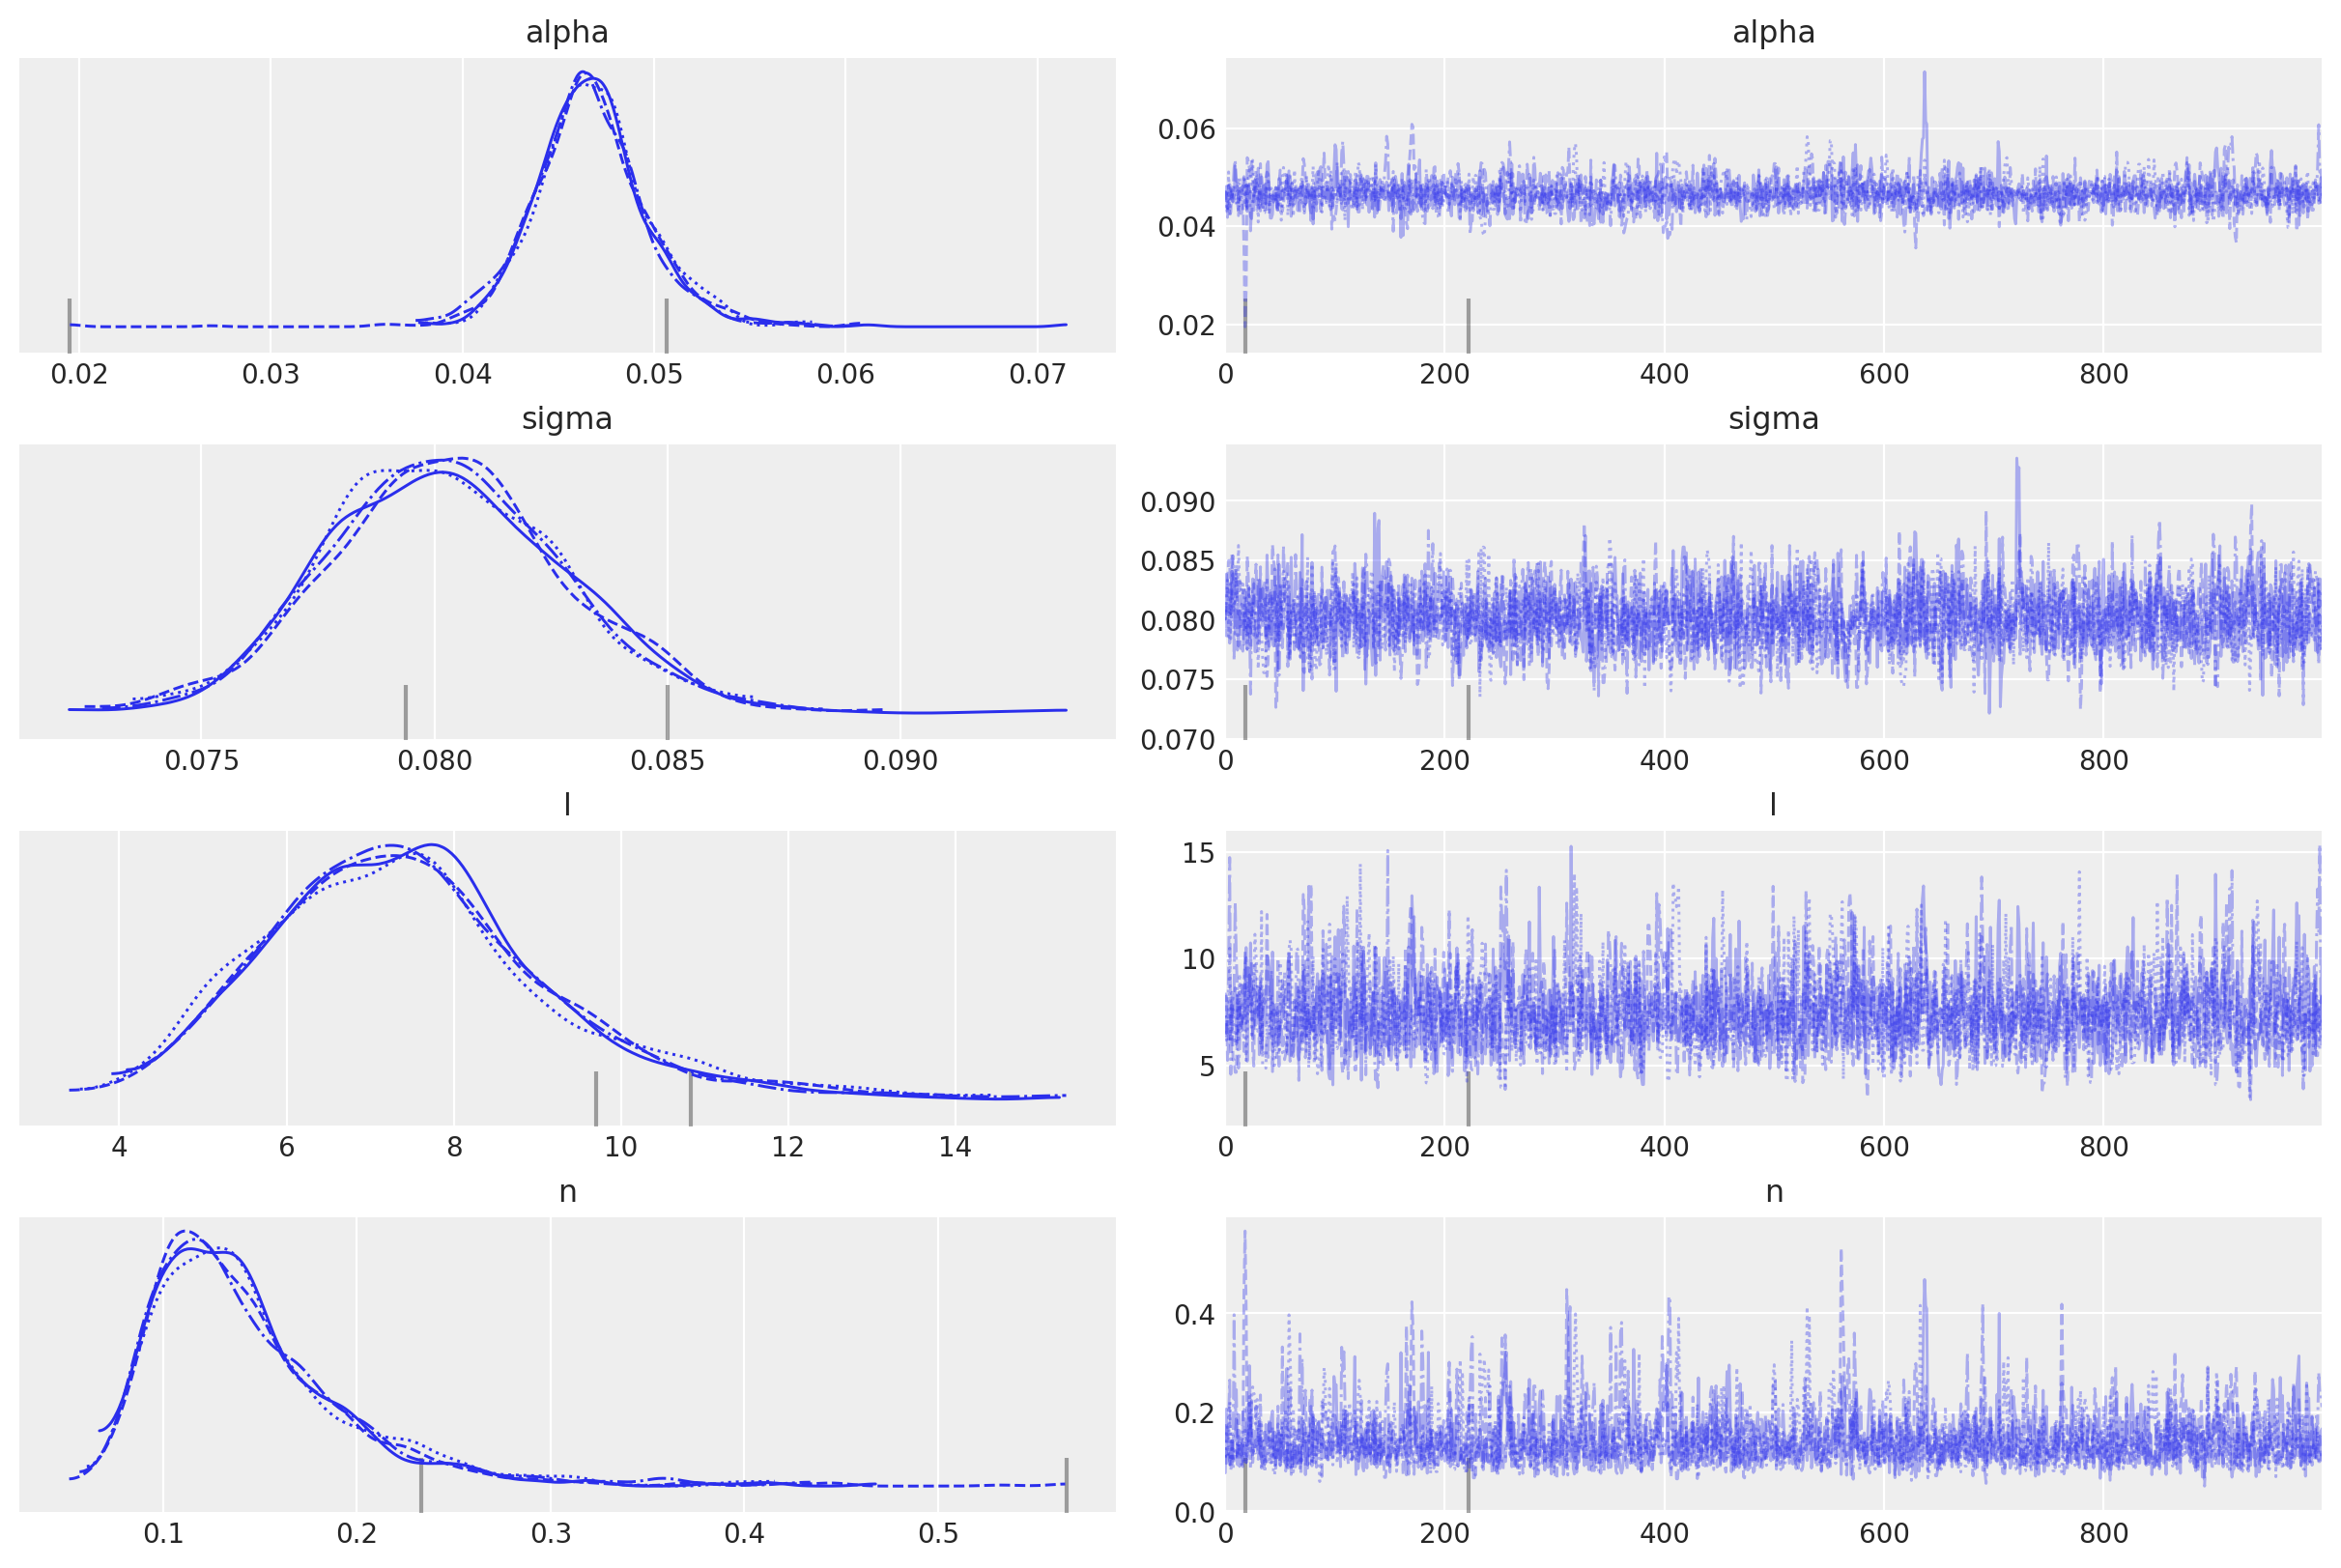

In [92]:
az.plot_trace(gp_trace, var_names=['alpha', 'sigma', 'l', 'n']);

### Prediction

In [93]:
with model1:
    y_pred = gp.conditional('y_pred', X.reshape(-1,1))

In [94]:
with model1:
    y_pred_test = gp.conditional('y_pred_test', X_test.reshape(-1,1))

In [95]:
with model1:
    y_pred_samples = pm.sample_posterior_predictive(gp_trace, 
                                                    var_names=['y_pred'], samples=1000)
    y_pred_test_samples = pm.sample_posterior_predictive(gp_trace, 
                                                    var_names=['y_pred_test'], samples=1000)

/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/.dcm/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/.dcm/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


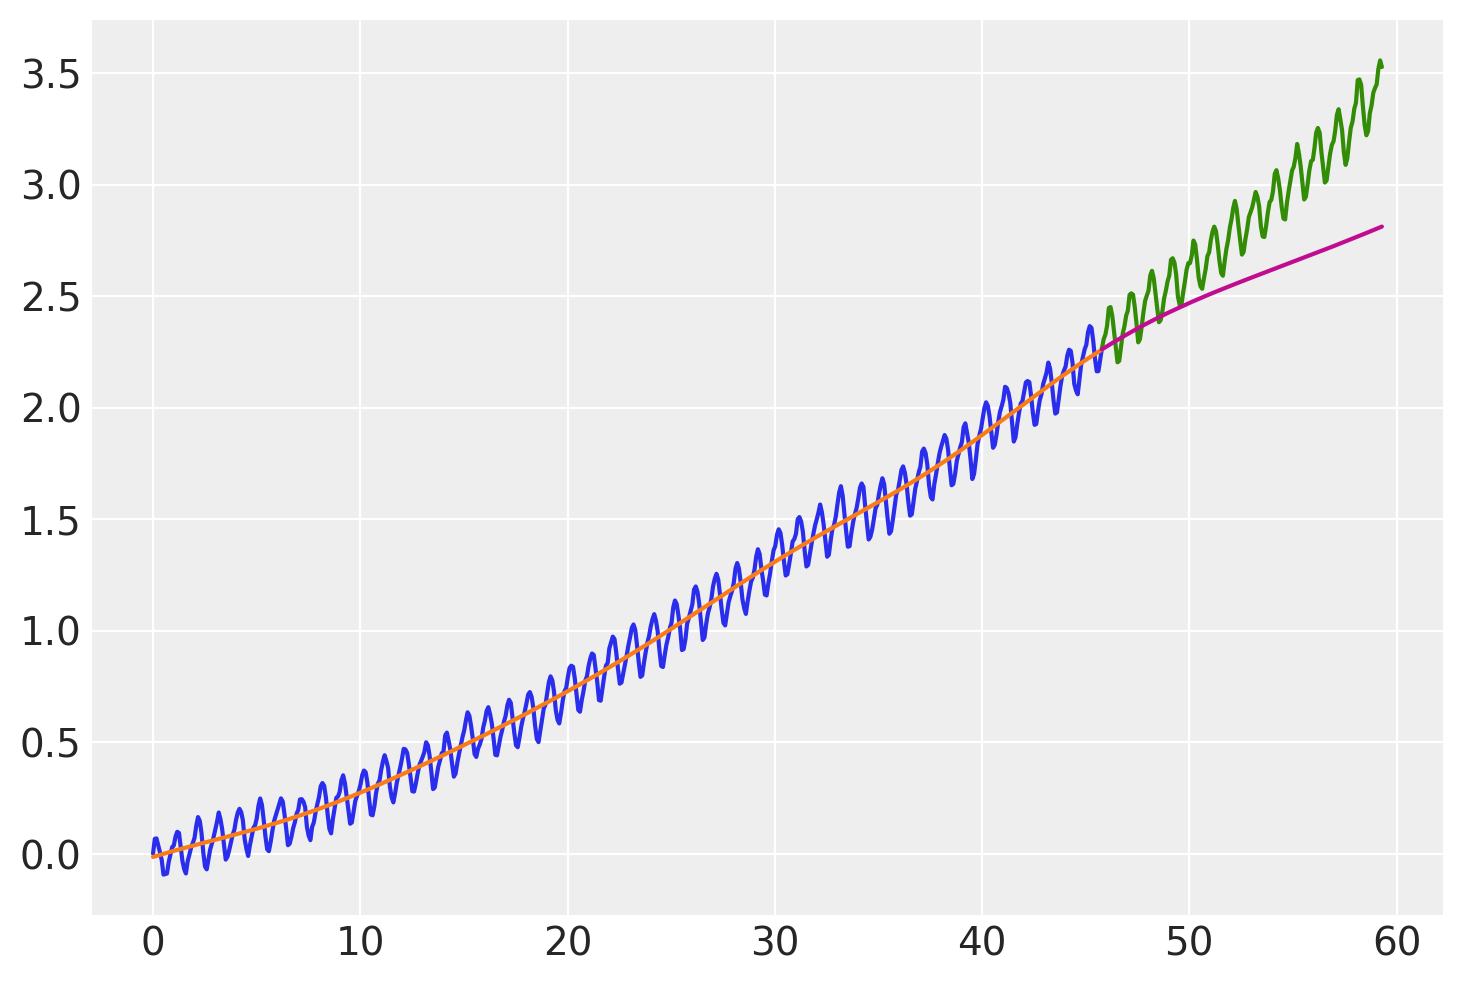

In [96]:
plt.plot(X, y)
plt.plot(X, y_pred_samples["y_pred"].mean(axis=0))
plt.plot(X_test, y_test)
plt.plot(X_test, y_pred_test_samples["y_pred_test"].mean(axis=0))